In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv

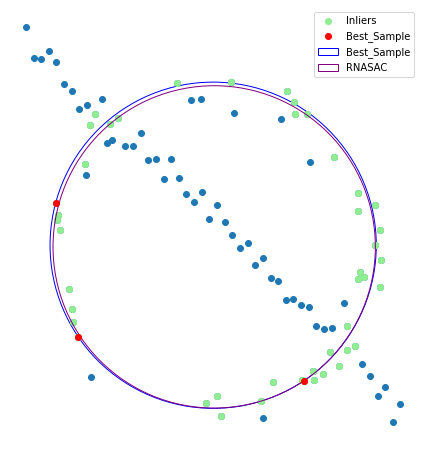

In [2]:
def getCircle(point_1, point_2, point_3):
    temp = point_2[0]**2 + point_2[1]**2
    bc = (point_1[0]**2 + point_1[1]**2 - temp)/2
    cd = (temp - point_3[0]**2 - point_3[1]**2)/2
    det = (point_1[0] - point_2[0]) * (point_2[1] - point_3[1]) - (point_2[0] - point_3[0]) * (point_1[1] - point_2[1])
    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(point_2[1] - point_3[1]) - cd*(point_1[1] - point_2[1]))/ det
    cy = ((point_1[0] - point_2[0]) * cd - (point_2[0] - point_3[0])*bc)/ det
    r = ((cx - point_1[0])**2 + (cy - point_1[1])**2)**0.5
    return cx, cy, r

def Shortest_Distance(p,centerx,centery,radius):
    d= np.array(abs(((p[:,0]-centerx)**2+(p[:,1]-centery)**2)**0.5-radius))
    return d

def RNASAC_(Data,iteration,threshold,no_inlieres):
    maximum=0
    out=np.array([])
    for i in range(iteration):
        randomPoints=np.random.choice(Data.size//2, size=3, replace=False)
        centerx,centery,radius=getCircle(Data[randomPoints[0]],Data[randomPoints[1]],Data[randomPoints[2]])
        PO=Shortest_Distance(Data,centerx,centery,radius)
        if radius>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<threshold]
        if len(inliares)>no_inlieres:
            short_d=Shortest_Distance(inliares,centerx,centery,radius)
            mean = sum(short_d/short_d.size)
            if maximum < len(inliares):
                bestOne=mean
                out=randomPoints
                inliares_=inliares
            elif maximum == len(inliares) and bestOne>mean:
                bestOne=mean
                out=randomPoints
                inliares_=inliares
    return out,inliares_

def plotCircle(Data,Datalst,color='r'):
    centerx,centery,radius=getCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((centerx,centery),radius,fill=False)
    c.set_color(color)
    return c

N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x +b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

ranL,bestInlier=RNASAC_(X,500,1,40)          
circle1=plotCircle(ranL,X, color = 'blue')
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( circle1 )
p1=ax.scatter(X[:,0],X[:,1])
Inliers=ax.scatter(bestInlier[:,0],bestInlier[:,1], color='lightgreen' )
bestfit,inl=RNASAC_(bestInlier,50,1,bestInlier.size//2.2)
circle2=plotCircle(bestfit,bestInlier, color ='purple')
ax.add_artist( circle2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Bestsamples=ax.scatter(Y[:,0],Y[:,1], c = 'r')
plt.legend(handles=[Inliers,Bestsamples,circle1,circle2],labels=['Inliers','Best_Sample','Best_Sample','RNASAC'])
ax.axis('off')
plt.show()

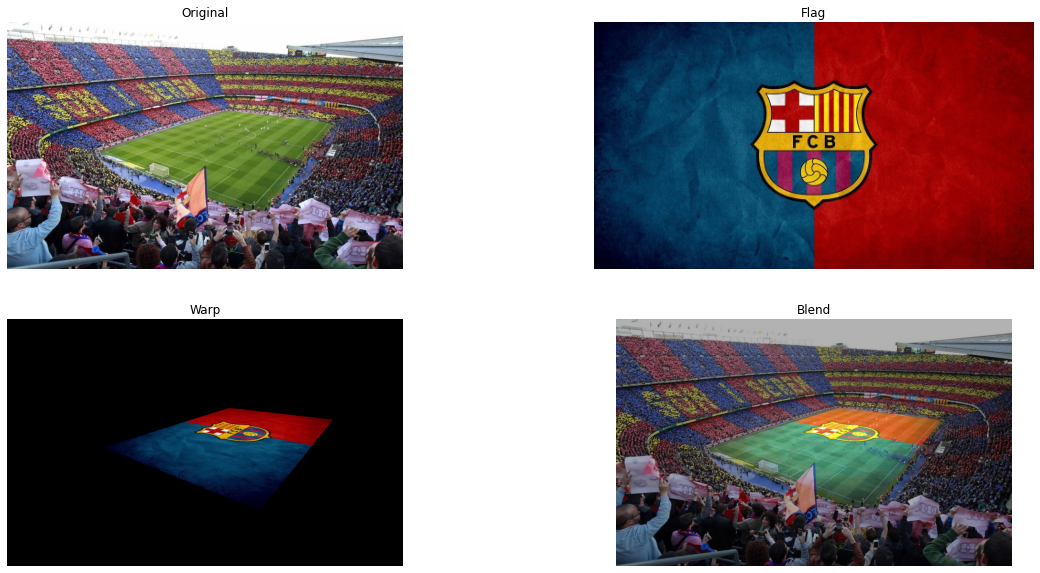

In [4]:
count = 0
points = []
def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None

img_background = cv.imread(r'CampNou.jpg', cv.IMREAD_COLOR)
img_flag = cv.imread(r'BarcaLogo.jpg', cv.IMREAD_REDUCED_COLOR_4)

cv.imshow("original image", img_background)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows()

points_src = np.array([[0,0], [img_flag.shape[1],0], [0, img_flag.shape[0]], [img_flag.shape[1],img_flag.shape[0]]]) 
points_dst = np.array(points)

h , status = cv.findHomography(points_src, points_dst,cv.RANSAC, 5.0)
img_warp = cv.warpPerspective(img_flag, h, (img_background.shape[1], img_background.shape[0]))
blend_image = cv.addWeighted(img_background, 0.7, img_warp, 0.85, 0.0)

fig, ax = plt.subplots(2,2, figsize = (20,10))
ax[0,0].imshow(cv.cvtColor(img_background, cv.COLOR_BGR2RGB))
ax[0,0].set_title("Original")
ax[0,0].axis('off') 
ax[0,1].imshow(cv.cvtColor(img_flag, cv.COLOR_BGR2RGB))
ax[0,1].set_title("Flag")
ax[0,1].axis('off') 
ax[1,0].imshow(cv.cvtColor(img_warp, cv.COLOR_BGR2RGB))
ax[1,0].set_title("Warp")
ax[1,0].axis('off')
ax[1,1].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB))
ax[1,1].set_title("Blend")
ax[1,1].axis('off')
plt.show()  